In [1]:
#import from drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
#import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

## 1. Data Pre-processing

In [3]:
#import steam 200k dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/steam/steam-200k.csv', names=['user_id','game','behaviour','value','other'])

In [4]:
df.head()

,user_id,game,behaviour,value,other
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0


In [5]:
#dropping irrelevant columns
df = df.drop('other', axis=1)
df.head()

,user_id,game,behaviour,value
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0
1,151603712,The Elder Scrolls V Skyrim,play,273.0
2,151603712,Fallout 4,purchase,1.0
3,151603712,Fallout 4,play,87.0
4,151603712,Spore,purchase,1.0


In [6]:
df.isna().any()

user_id      False
game         False
behaviour    False
value        False
dtype: bool

## 2. Exploratory Data Analysis

In [7]:
#dataframe with playtime data
play_df = df[df['behaviour']=='play'].rename(columns={'value': 'hours_played'}).drop('behaviour',axis=1)
play_df.head()

,user_id,game,hours_played
1,151603712,The Elder Scrolls V Skyrim,273.0
3,151603712,Fallout 4,87.0
5,151603712,Spore,14.9
7,151603712,Fallout New Vegas,12.1
9,151603712,Left 4 Dead 2,8.9


In [8]:
print("Number of games: ", len(play_df['game'].unique()))
print("Number of users: ", len(play_df['user_id'].unique()))

Number of games:  3600
Number of users:  11350


In [9]:
#descriptive stats for playtime data
play_df.describe()

,user_id,hours_played
count,7.048900e+04,70489.000000
mean,1.058812e+08,48.878063
std,7.150365e+07,229.335236
min,5.250000e+03,0.100000
25%,4.934256e+07,1.000000
50%,9.169067e+07,4.500000
75%,1.556738e+08,19.100000
max,3.099031e+08,11754.000000


### 2.1. Distribution of user behaviour

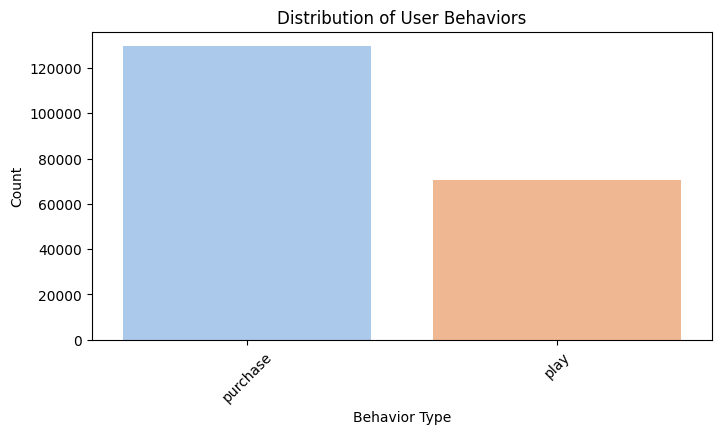

In [10]:
# Distribution of user behaviors
behavior_counts = df['behaviour'].value_counts()

plt.figure(figsize=(8, 4))
sns.barplot(x=behavior_counts.index, y=behavior_counts.values, hue=behavior_counts.index, palette="pastel")
plt.title('Distribution of User Behaviors')
plt.xlabel('Behavior Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### 2.2. Distribution of playtime

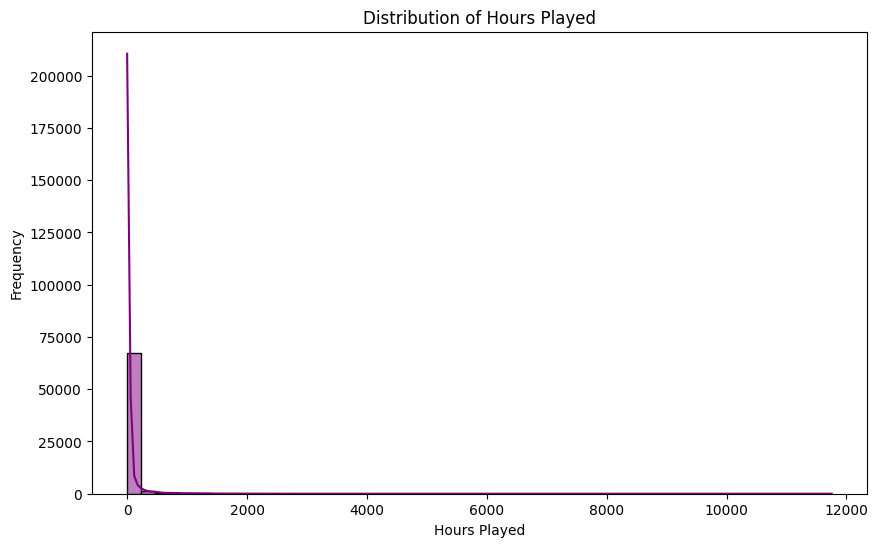

In [11]:
# Distribution of playtime values
plt.figure(figsize=(10, 6))
sns.histplot(play_df['hours_played'], bins=50, kde=True, color='purple')
plt.title('Distribution of Hours Played')
plt.xlabel('Hours Played')
plt.ylabel('Frequency')
plt.show()


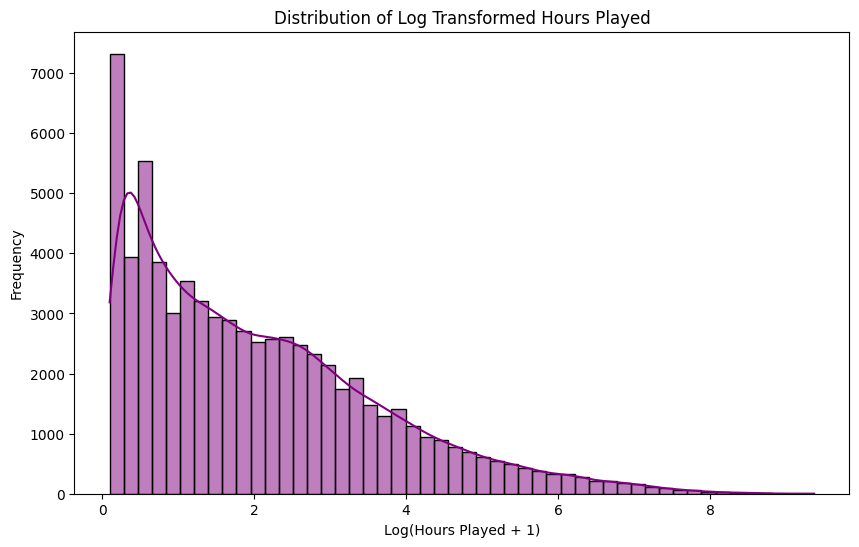

In [12]:
# Distribution of playtime with log transformation
play_df['log_value'] = np.log1p(play_df['hours_played'])

plt.figure(figsize=(10, 6))
sns.histplot(play_df['log_value'], bins=50, kde=True, color='purple')
plt.title('Distribution of Log Transformed Hours Played')
plt.xlabel('Log(Hours Played + 1)')
plt.ylabel('Frequency')
plt.show()


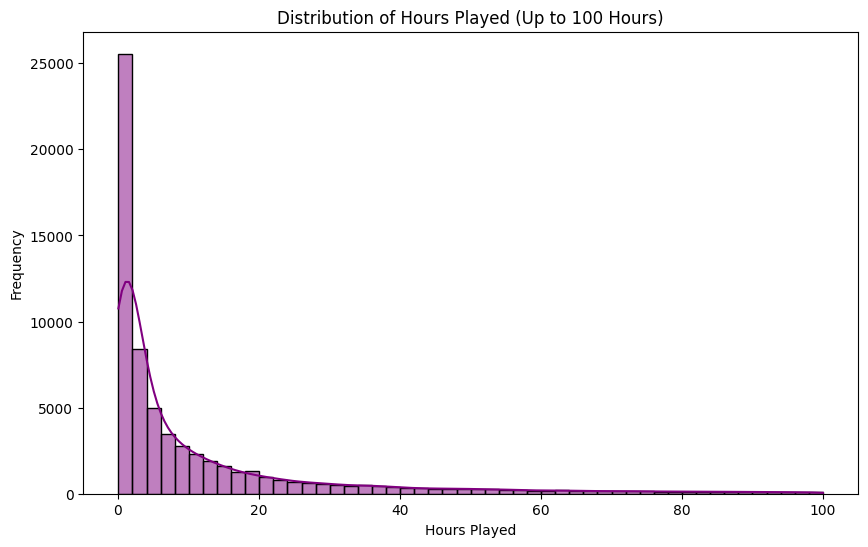

In [13]:
# Distribution of Playtime (up to 100 hours)
plt.figure(figsize=(10, 6))
sns.histplot(play_df[play_df['hours_played'] <= 100]['hours_played'], bins=50, color = 'purple', kde=True)
plt.title('Distribution of Hours Played (Up to 100 Hours)')
plt.xlabel('Hours Played')
plt.ylabel('Frequency')
plt.show()

## 3. User and Game Analysis

### 3.1 Most Played Games

In [14]:
# Top games by playtime
top_games = play_df.groupby('game')['hours_played'].sum().nlargest(10).reset_index()

fig = px.bar(top_games, x='hours_played', y='game', orientation='h', title='Top 10 Games by Total Playtime',
             labels={'hours_played': 'Total Playtime (hours)', 'game': 'Game Title'}, color = 'hours_played')
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()


### 3.2. Playtime per User

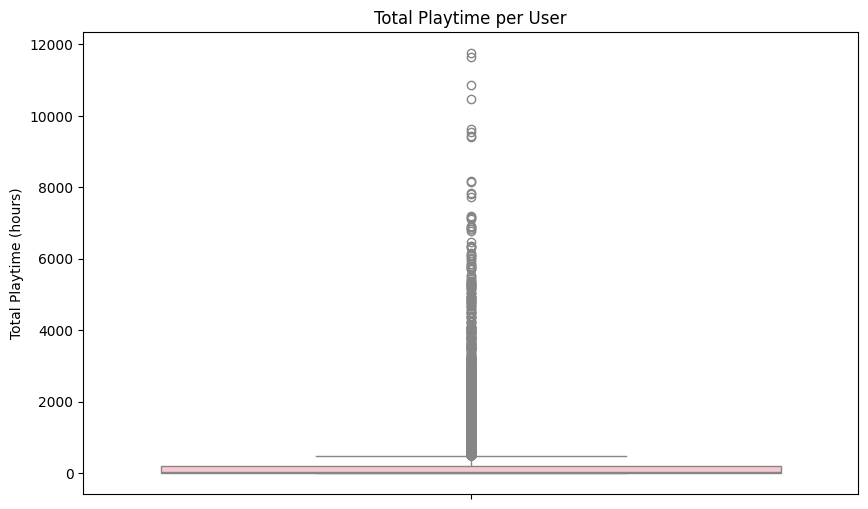

In [15]:
# Total playtime per user
user_playtime = play_df.groupby('user_id')['hours_played'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.boxplot(y='hours_played', data=user_playtime, color='pink')
plt.title('Total Playtime per User')
plt.ylabel('Total Playtime (hours)')
plt.show()


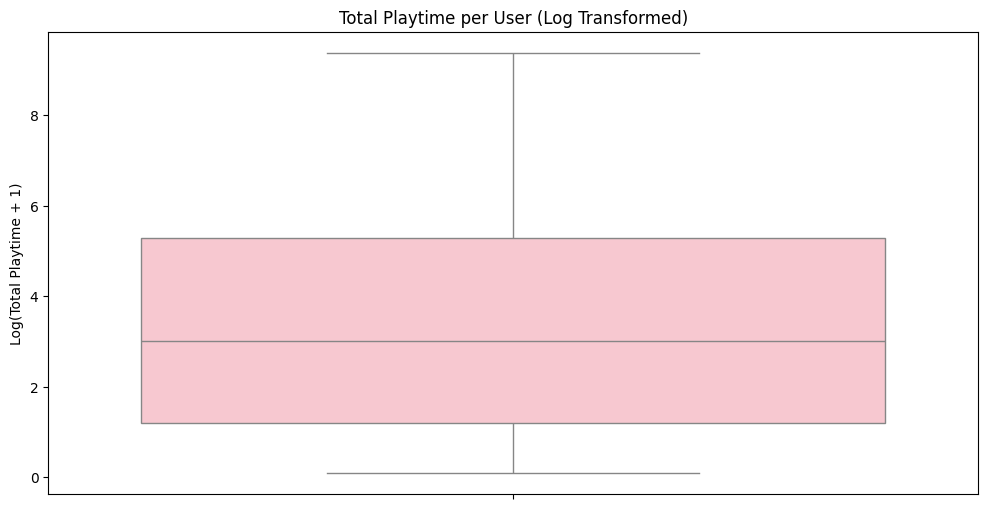

In [16]:
# Apply log transformation
user_playtime['log_hours_played'] = np.log1p(user_playtime['hours_played'])

# Total Playtime per User with Log Transformation
plt.figure(figsize=(12, 6))
sns.boxplot(y='log_hours_played', data=user_playtime, color='pink')
plt.title('Total Playtime per User (Log Transformed)')
plt.ylabel('Log(Total Playtime + 1)')
plt.show()

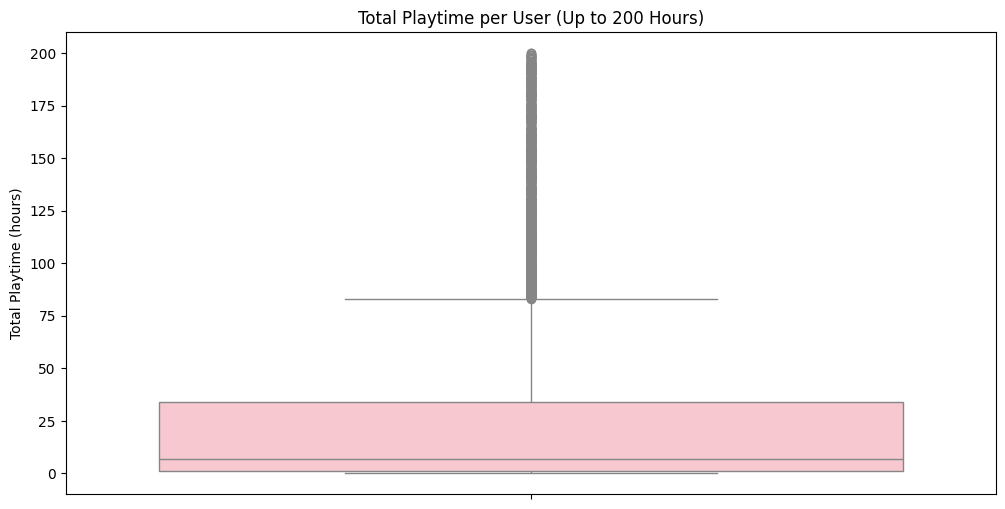

In [17]:
# Total Playtime per User (Zoomed in)
plt.figure(figsize=(12, 6))
sns.boxplot(y='hours_played', data=user_playtime[user_playtime['hours_played'] <= 200], color='pink')
plt.title('Total Playtime per User (Up to 200 Hours)')
plt.ylabel('Total Playtime (hours)')
plt.show()

### 3.2 User Segmentation - Clustering Users Based on Playtime

In [29]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Standardizing the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(play_df[['hours_played']])

# Applying KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
play_df['cluster'] = kmeans.fit_predict(scaled_features)

# Visualizing the clusters
fig = px.scatter(play_df, x='user_id', y='hours_played', color='cluster',
                 title='Clusters of Users Based on Playtime',
                 labels={'user_id': 'User ID', 'hours_played': 'Hours Played'})

# Update color scale to be discrete
fig.update_traces(marker=dict(coloraxis="coloraxis"))
fig.update_layout(coloraxis=dict(
    colorbar=dict(
        tickvals=[0, 1, 2, 3],
        ticktext=['0', '1', '2', '3']
    )
))

fig.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



## 4. Correlation and Feature Analysis

### 4.1. Playtime vs. Number of Games Played

In [70]:
# Playtime vs. Number of Games Played
user_game_count = play_df.groupby('user_id')['game'].nunique().reset_index()
user_game_count.columns = ['user_id', 'num_games']
user_playtime = play_df.groupby('user_id')['hours_played'].sum().reset_index()
user_playtime.columns = ['user_id', 'total_playtime']
merged_df = pd.merge(user_game_count, user_playtime, on='user_id')

fig = px.scatter(merged_df, x='num_games', y='total_playtime', title='Playtime vs. Number of Games Played',
                 labels={'num_games': 'Number of Games Played', 'total_playtime': 'Total Playtime (hours)'},
                 color='total_playtime')
fig.show()

### 4.2 Playtime vs Number of Purchases

In [73]:
# Purchase vs. Play Correlation
purchase_df = df[df['behaviour'] == 'purchase']
purchase_count = purchase_df.groupby('user_id')['value'].count().reset_index()
purchase_count.columns = ['user_id', 'num_purchases']
merged_df = pd.merge(purchase_count, user_playtime, on='user_id')

fig = px.scatter(merged_df, x='num_purchases', y='total_playtime', title='Purchase vs. Play Correlation',
                 labels={'num_purchases': 'Number of Purchases', 'total_playtime': 'Total Playtime (hours)'},
                 color='total_playtime')
fig.show()


## 5. Feature Engineering

In [75]:
# Calculate number of games played by each user
user_game_count = play_df.groupby('user_id')['game'].nunique().reset_index()
user_game_count.columns = ['user_id', 'num_games']

# Calculate total playtime for each user
user_playtime = play_df.groupby('user_id')['hours_played'].sum().reset_index()
user_playtime.columns = ['user_id', 'total_playtime']

# Filter purchase data
purchase_df = df[df['behaviour'] == 'purchase'].rename(columns={'value': 'purchases'}).drop('behaviour', axis=1)

# Calculate the number of purchases by each user
purchase_count = purchase_df.groupby('user_id')['purchases'].count().reset_index()
purchase_count.columns = ['user_id', 'num_purchases']

# Merge all features into a single DataFrame
merged_df = user_game_count.merge(user_playtime, on='user_id').merge(purchase_count, on='user_id', how='left')

# Fill any NaN values resulting from the merge
merged_df['num_purchases'].fillna(0, inplace=True)

# Create additional features
merged_df['avg_playtime_per_game'] = merged_df['total_playtime'] / merged_df['num_games']
merged_df['purchase_playtime_ratio'] = merged_df['total_playtime'] / merged_df['num_purchases']
merged_df['avg_playtime_per_game'].fillna(0, inplace=True)
merged_df['purchase_playtime_ratio'].replace([np.inf, -np.inf], 0, inplace=True)
merged_df['purchase_playtime_ratio'].fillna(0, inplace=True)

# Prepare features and target
features = merged_df.drop(columns=['user_id', 'total_playtime'])
target = merged_df['total_playtime']

print(features.head())
print(target.head())

   num_games  num_purchases  avg_playtime_per_game  purchase_playtime_ratio
0          6             21              37.583333                10.738095
1         20             36              61.350000                34.083333
2         15             82              17.000000                 3.109756
3          1              8               0.100000                 0.012500
4          2             12               1.100000                 0.183333
0     225.5
1    1227.0
2     255.0
3       0.1
4       2.2
Name: total_playtime, dtype: float64


## 6. Dataset Split

In [76]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

## 7. Model Training

### 7.1. Linear Regression

Linear Regression MSE: 278291.6601635505
Linear Regression R^2: 0.5279389195416294
Linear Regression Cross-validation scores: [0.45276197 0.53657965 0.56516573 0.59495035 0.11805246]
Linear Regression Mean CV score: 0.4535020310140732


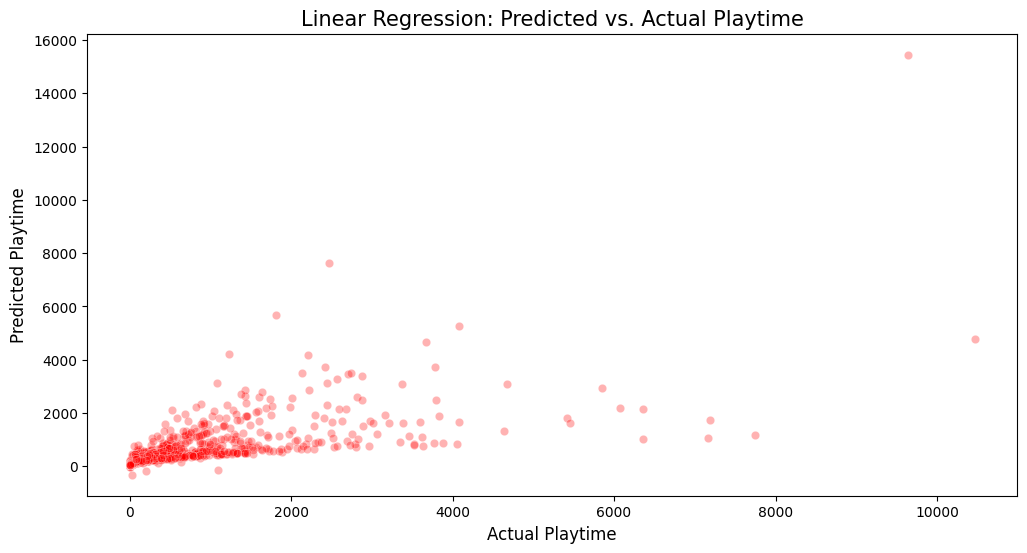

In [77]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test)

# Evaluate the Linear Regression model
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression MSE: {mse_lr}")
print(f"Linear Regression R^2: {r2_lr}")

# Perform cross-validation for Linear Regression
cv_scores_lr = cross_val_score(lr_model, features, target, cv=5)
print(f"Linear Regression Cross-validation scores: {cv_scores_lr}")
print(f"Linear Regression Mean CV score: {cv_scores_lr.mean()}")

# Plot predicted vs. actual playtime for Linear Regression
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_test, y=y_pred_lr, alpha=0.3, color='red')
plt.title('Linear Regression: Predicted vs. Actual Playtime', fontsize=15)
plt.xlabel('Actual Playtime', fontsize=12)
plt.ylabel('Predicted Playtime', fontsize=12)
plt.show()

### 7.2. Random Forest Regressor

<ipython-input-78-0c1282237b87>:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




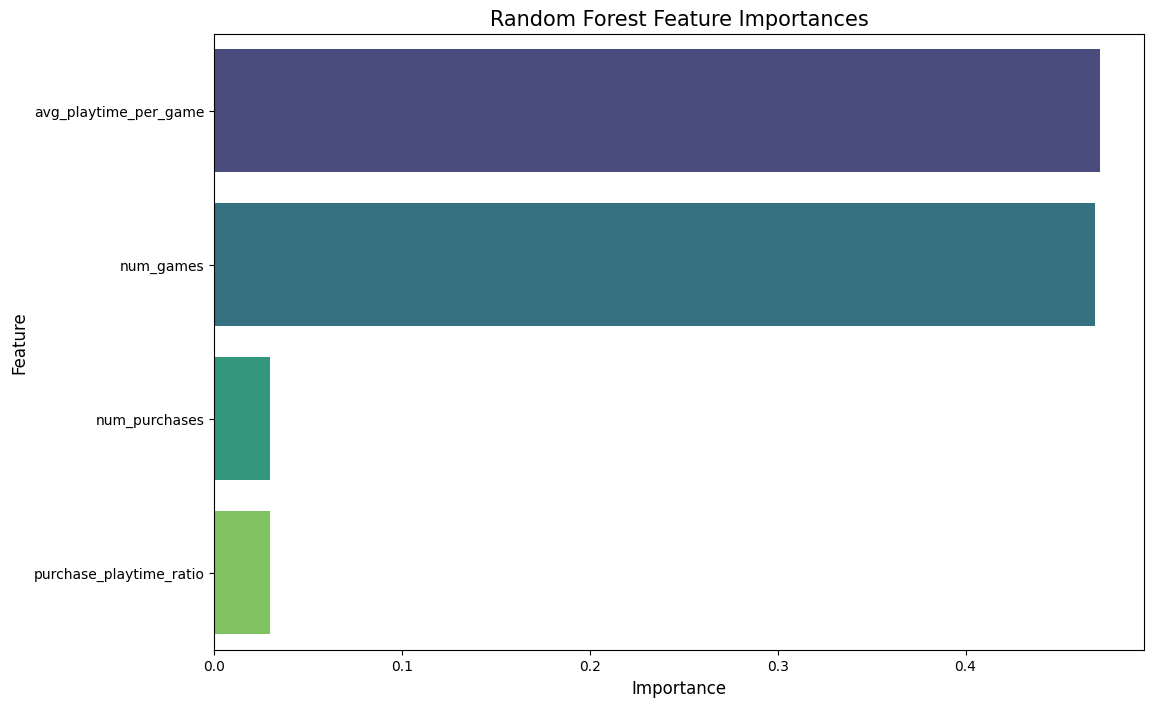

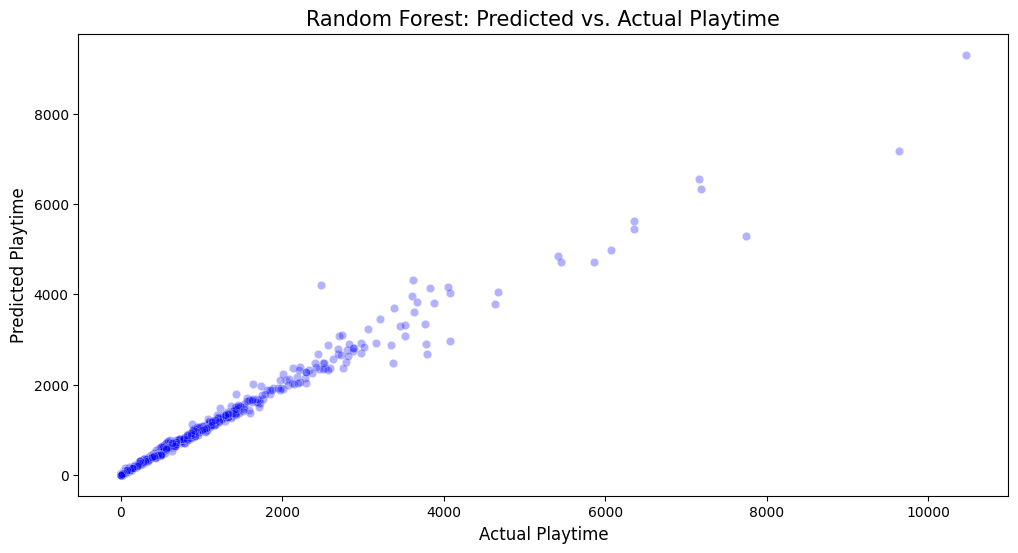

Random Forest Cross-validation scores: [0.90263433 0.96482019 0.97682529 0.99231682 0.99110943]
Random Forest Mean CV score: 0.9655412119056812


In [78]:
# Train RandomForestRegressor model
rf_model = RandomForestRegressor(n_estimators=200, max_depth=7, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Feature importances
rf_importances = rf_model.feature_importances_
feature_importances_rf = pd.DataFrame({'feature': features.columns, 'importance': rf_importances})
feature_importances_rf = feature_importances_rf.sort_values(by='importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances_rf, palette='viridis')
plt.title('Random Forest Feature Importances', fontsize=15)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

# Predicted vs. Actual playtime for Random Forest
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.3, color='blue')
plt.title('Random Forest: Predicted vs. Actual Playtime', fontsize=15)
plt.xlabel('Actual Playtime', fontsize=12)
plt.ylabel('Predicted Playtime', fontsize=12)
plt.show()

# Perform cross-validation for Random Forest
from sklearn.model_selection import cross_val_score
cv_scores_rf = cross_val_score(rf_model, features, target, cv=5)
print(f"Random Forest Cross-validation scores: {cv_scores_rf}")
print(f"Random Forest Mean CV score: {cv_scores_rf.mean()}")


### 7.3. XGBoost

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


<ipython-input-79-5fc04b38aaa2>:33: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




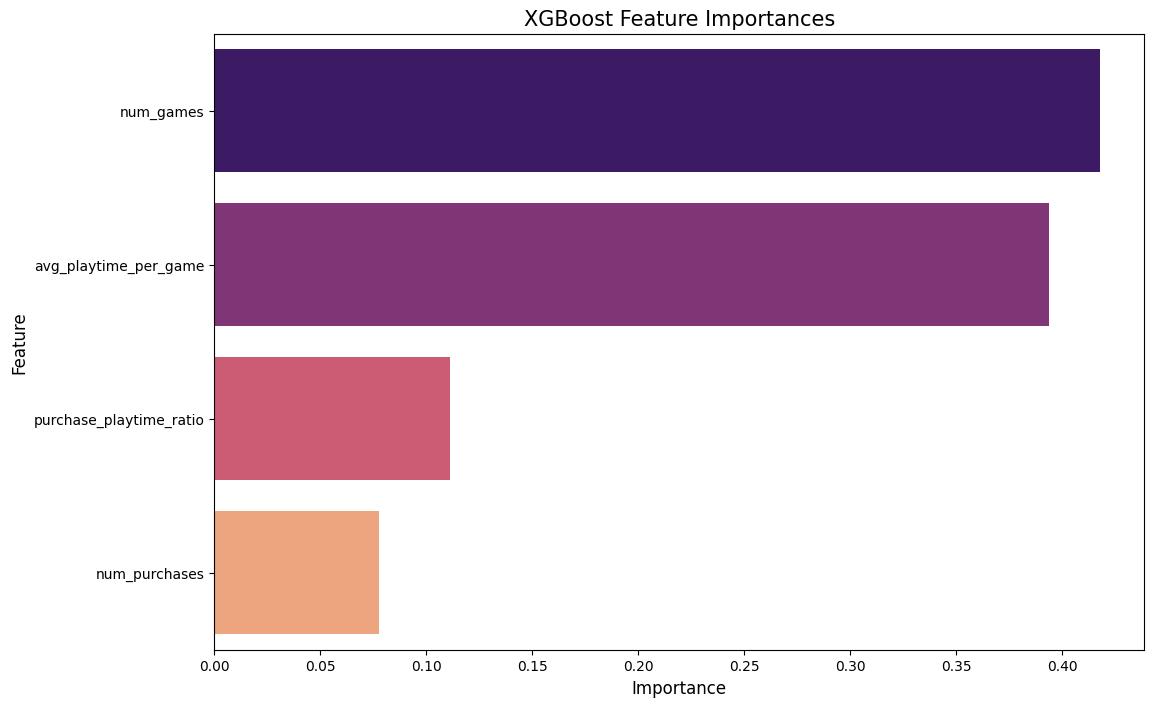

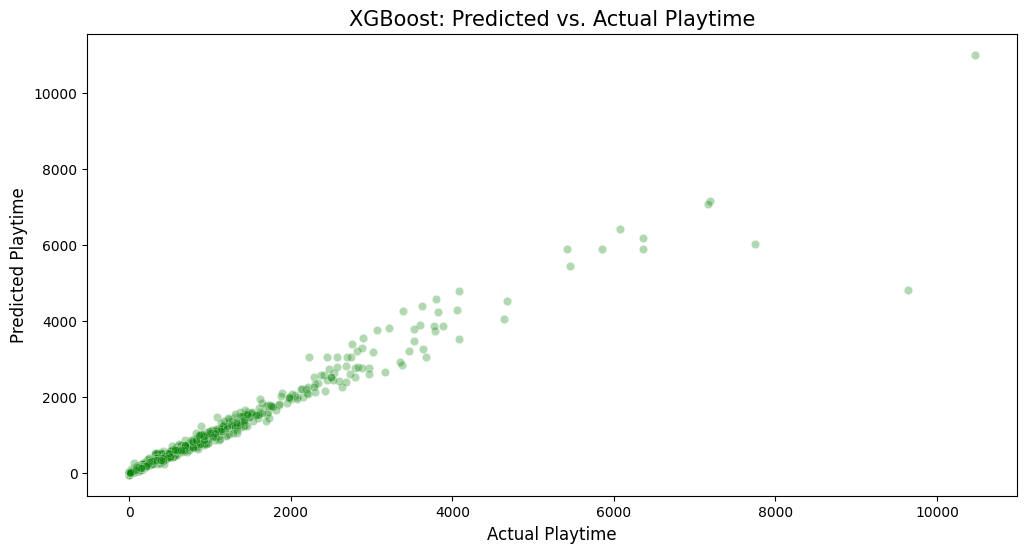

XGBoost Cross-validation scores: [0.94666966 0.94763344 0.94837913 0.9804119  0.98256351]
XGBoost Mean CV score: 0.9611315280286788


In [79]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Define the model
xgb_model = XGBRegressor(random_state=42)

# Hyperparameter tuning with Grid Search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Evaluate the best model
best_xgb_model = grid_search.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test)

# Feature importances
xgb_importances = best_xgb_model.feature_importances_
feature_importances_xgb = pd.DataFrame({'feature': features.columns, 'importance': xgb_importances})
feature_importances_xgb = feature_importances_xgb.sort_values(by='importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances_xgb, palette='magma')
plt.title('XGBoost Feature Importances', fontsize=15)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

# Predicted vs. Actual playtime for XGBoost
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_test, y=y_pred_xgb, alpha=0.3, color='green')
plt.title('XGBoost: Predicted vs. Actual Playtime', fontsize=15)
plt.xlabel('Actual Playtime', fontsize=12)
plt.ylabel('Predicted Playtime', fontsize=12)
plt.show()

# Perform cross-validation for XGBoost
cv_scores_xgb = cross_val_score(best_xgb_model, features, target, cv=5)
print(f"XGBoost Cross-validation scores: {cv_scores_xgb}")
print(f"XGBoost Mean CV score: {cv_scores_xgb.mean()}")


### 8. Model Comparison & Evaluation

Linear Regression Mean CV score: 0.4535020310140732
Random Forest Mean CV score: 0.9655412119056812
XGBoost Mean CV score: 0.9611315280286788
Model Performance Comparison:
Linear Regression: Mean CV score = 0.4535
Random Forest: Mean CV score = 0.9655
XGBoost: Mean CV score = 0.9611


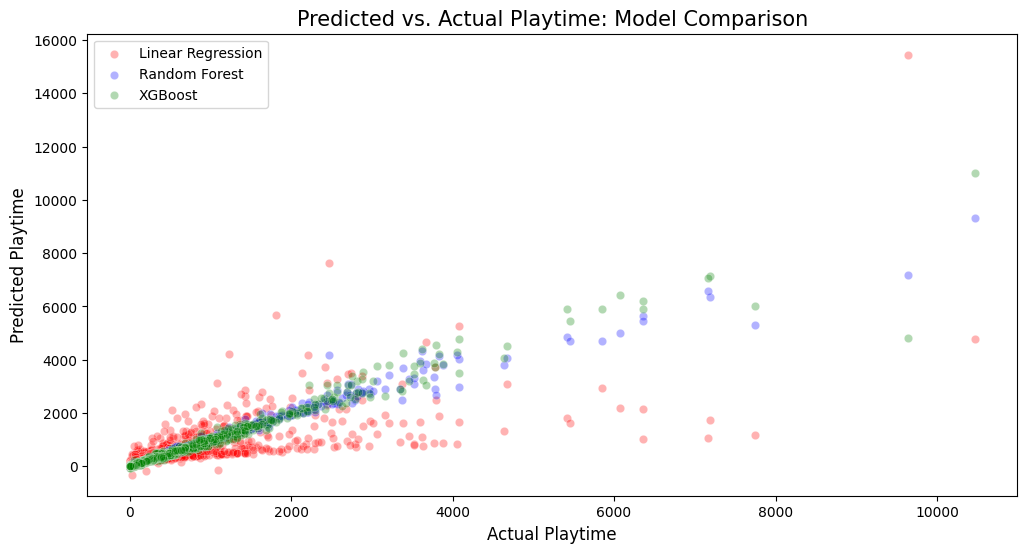

In [80]:
# Compare Cross-validation Scores
print(f"Linear Regression Mean CV score: {cv_scores_lr.mean()}")
print(f"Random Forest Mean CV score: {cv_scores_rf.mean()}")
print(f"XGBoost Mean CV score: {cv_scores_xgb.mean()}")

# Comparison summary
print("Model Performance Comparison:")
print(f"Linear Regression: Mean CV score = {cv_scores_lr.mean():.4f}")
print(f"Random Forest: Mean CV score = {cv_scores_rf.mean():.4f}")
print(f"XGBoost: Mean CV score = {cv_scores_xgb.mean():.4f}")

# Plot all predicted vs actual playtime in a single plot for better comparison
plt.figure(figsize=(12, 6))

# Linear Regression
sns.scatterplot(x=y_test, y=y_pred_lr, alpha=0.3, color='red', label='Linear Regression')

# Random Forest
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.3, color='blue', label='Random Forest')

# XGBoost
sns.scatterplot(x=y_test, y=y_pred_xgb, alpha=0.3, color='green', label='XGBoost')

plt.title('Predicted vs. Actual Playtime: Model Comparison', fontsize=15)
plt.xlabel('Actual Playtime', fontsize=12)
plt.ylabel('Predicted Playtime', fontsize=12)
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



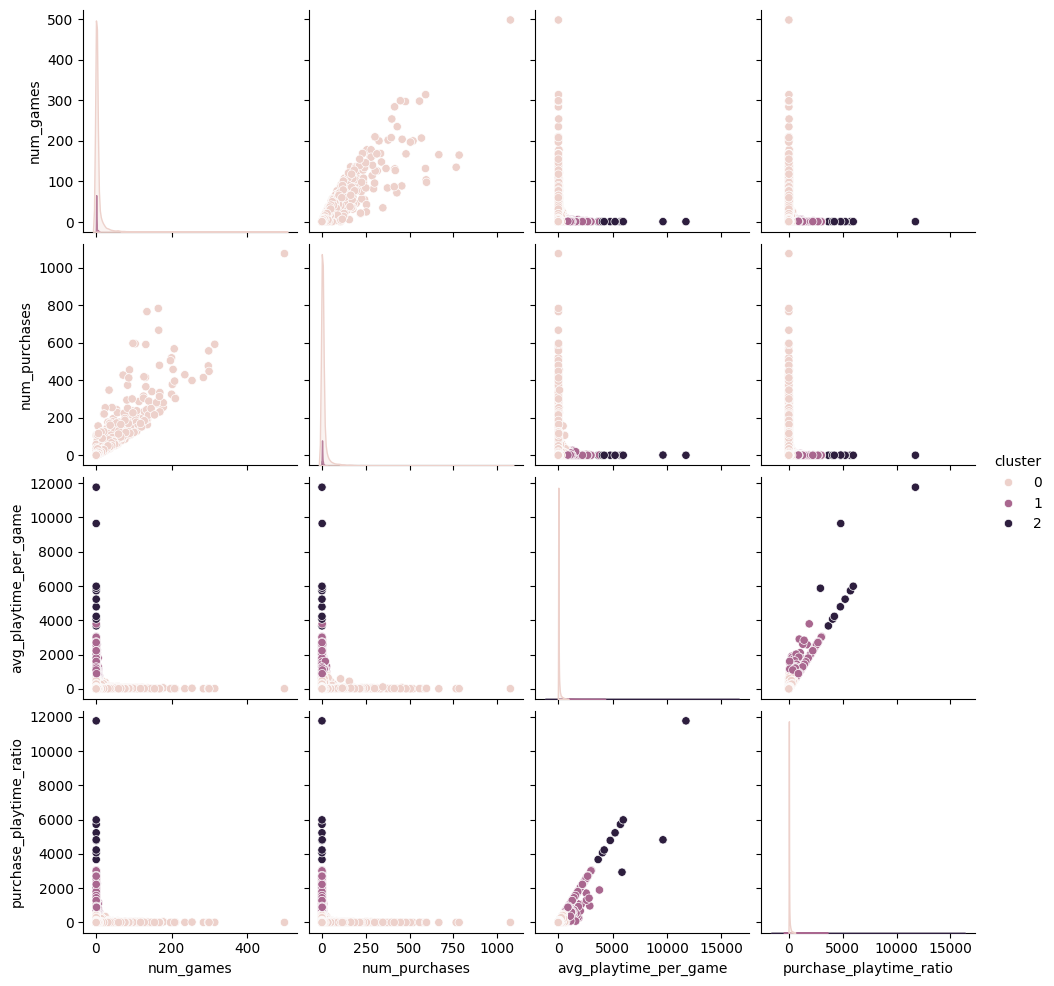

In [84]:
from sklearn.cluster import KMeans

# Prepare the data for clustering
clustering_features = features[['num_games', 'num_purchases', 'avg_playtime_per_game', 'purchase_playtime_ratio']]

# Perform K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(clustering_features)

# Add cluster labels to the original DataFrame
merged_df['cluster'] = clusters

# Visualize the clusters
sns.pairplot(merged_df, hue='cluster', vars=['num_games', 'num_purchases', 'avg_playtime_per_game', 'purchase_playtime_ratio'])
plt.show()
